<a href="https://colab.research.google.com/github/IronicNinja/interesting_colabs/blob/master/Roller_Coaster_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade gspread

  Found existing installation: gspread 3.0.1
    Uninstalling gspread-3.0.1:
      Successfully uninstalled gspread-3.0.1


In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
import pandas as pd
import numpy as np
ws = gc.open('ZLZL Rollercoaster Data')
sheet = ws.worksheet('RC Converted Data')
df = pd.DataFrame(sheet.get_all_records())
df

,Name,Type,Height (feet),Speed (mph),Length (feet),Inversions (YES or NO),Number of Inversions,Drop (feet),Duration (min:sec),G Force,Vertical Angle (degrees)
0,Kingda Ka,Sit Down,456.0,128.0,3118.0,NO,0,418.0,0:28,,90
1,Top Thrill Dragster,Sit Down,420.0,120.0,2800.0,NO,0,400.0,0:30,,90
2,Superman: Escape from Krypton,Sit Down,415.0,100.0,1235.0,NO,0,328.1,0:28,4.5,
3,Tower of Terror II,Sit Down,377.3,100.0,1235.0,NO,0,328.1,0:28,4.5,90
4,Fury 325,Sit Down,325.0,95.0,6602.0,NO,0,320.0,,,81
...,...,...,...,...,...,...,...,...,...,...,...
133,Winjas,Sit Down,57.1,41.0,1526.6,NO,0,52.5,,,
134,Anaconda,Sit Down,118.1,55.9,3937.0,NO,0,40.0,2:10,,
135,Big Thunder Mountain,Sit Down,72.2,40.4,4921.3,NO,0,39.3,3:56,,
136,Backlot Stunt Coaster,Sit Down,45.2,40.0,1960.0,NO,0,31.2,1:04,,


In [ ]:
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

input_data = []
y_data = []
val_x_data = []
val_y_data = []
all_data = []
all_y_data = []

categorical_data = []
for x in range(len(df)):
  drop = df['Drop (feet)'][x]
  height = df['Height (feet)'][x]
  length = df['Length (feet)'][x]
  speed = df['Speed (mph)'][x]
  type_r = df['Type'][x]
  inversions = df['Inversions (YES or NO)'][x]
  params = [float(height), float(length), float(speed)]
  features = [float(height), float(speed)]

  all_data.append(params)
  all_y_data.append([float(drop)])
  categorical_data.append(type_r)
  if x < 110:
    input_data.append(params)
    y_data.append([float(drop)])

index = np.random.choice([x for x in range(len(all_data))], 30, replace=False)
for x in index:
  drop = df['Drop (feet)'][x]
  height = df['Height (feet)'][x]
  length = df['Length (feet)'][x]
  speed = df['Speed (mph)'][x]
  val_x_data.append([float(height), float(length), float(speed)])
  val_y_data.append([float(drop)])

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(input_data)
scaler1 = MinMaxScaler(feature_range=(0, 1))
y_scaled_data = scaler1.fit_transform(y_data)

scaler_x = MinMaxScaler(feature_range=(0,1))
scaled_val_x_data = scaler_x.fit_transform(val_x_data)
scaler_y = MinMaxScaler(feature_range=(0,1))
scaled_val_y_data = scaler_y.fit_transform(val_y_data)

scaler_all = MinMaxScaler(feature_range=(0,1))
all_scaled_data = scaler_all.fit_transform(all_data)
scaler_all_y = MinMaxScaler(feature_range=(0,1))
all_scaled_y_data = scaler_all_y.fit_transform(all_y_data)

In [ ]:
def train_model(neurons, scaled_data, y_scaled_data, epochs):
  test_model = Sequential()
  test_model.add(Dense(3))
  test_model.add(Dense(neurons))
  test_model.add(Dense(neurons))
  test_model.add(Dense(1))
  test_model.compile(loss='mse', optimizer='adam')
  history = test_model.fit(scaled_data, y_scaled_data, epochs=epochs, batch_size=1, validation_data=(scaled_val_x_data, scaled_val_y_data), verbose=0)

  plt.plot(history.history['val_loss'])
  #plt.show()
  last_50 = [history.history['val_loss'][x] for x in range(int(epochs/2), epochs)]
  return history, test_model, np.mean(last_50)

0.007853538609109818


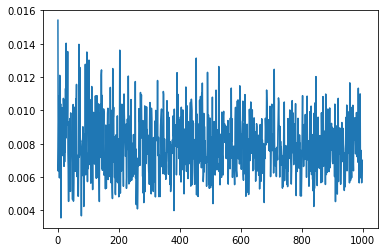

In [ ]:
history, model, mean_val = train_model(16, all_scaled_data, all_scaled_y_data, 1000)
print(mean_val)

In [ ]:
prod_sheet = ws.worksheet('RC Data With Drops')
prod_df = pd.DataFrame(prod_sheet.get_all_records())

all_test_data = []
all_test_data_y = []
drop_indices = []
ind = 0
for x in range(len(prod_df)):
  height = prod_df['Height (feet)'][x]
  length = prod_df['Length (feet)'][x]
  speed = prod_df['Speed (mph)'][x]
  params_all = [float(height), float(length), float(speed)]
  features_all = [float(height), float(speed)]

  all_test_data.append(params_all)

  drop = prod_df['Drop (feet)'][x]
  if drop:
    drop_indices.append(x)
    all_test_data_y.append([float(drop)])

scaler_h_l = MinMaxScaler(feature_range=(0,1))
h_l_data = scaler_h_l.fit_transform(all_test_data)

scaler_h_l_y = MinMaxScaler(feature_range=(0,1))
test_y_data = scaler_h_l_y.fit_transform(all_test_data_y)

pred = model.predict(h_l_data)
real_val = scaler_h_l_y.inverse_transform(pred)
#real_val

In [ ]:
def regression(var1, var2):
  return 0.35085918*var1+2.9360106*var2-93.010323

predicted_data = ws.worksheet('RC Predicted Data')

def do():
  for x in range(len(real_val)):
    if x not in drop_indices:
      predicted_data.update('H' + str(2+x), round(float(real_val[x][0]), 3))
      predicted_data.update('I' + str(2+x), round(regression(all_test_data[x][0], all_test_data[x][2]), 3))

In [ ]:
cnt = 0
summ = 0
other_summ = 0
for x in drop_indices:
  num = abs(real_val[x] - all_test_data_y[cnt][0])
  summ += num
  other_summ += abs(regression(all_test_data[x][0], all_test_data[x][2]) - all_test_data_y[cnt][0])
  cnt += 1

print(summ, cnt, summ/cnt)
print(other_summ, other_summ/cnt)

[2091.5813] 138 [15.156386]
1542.6551833559995 11.178660748956519


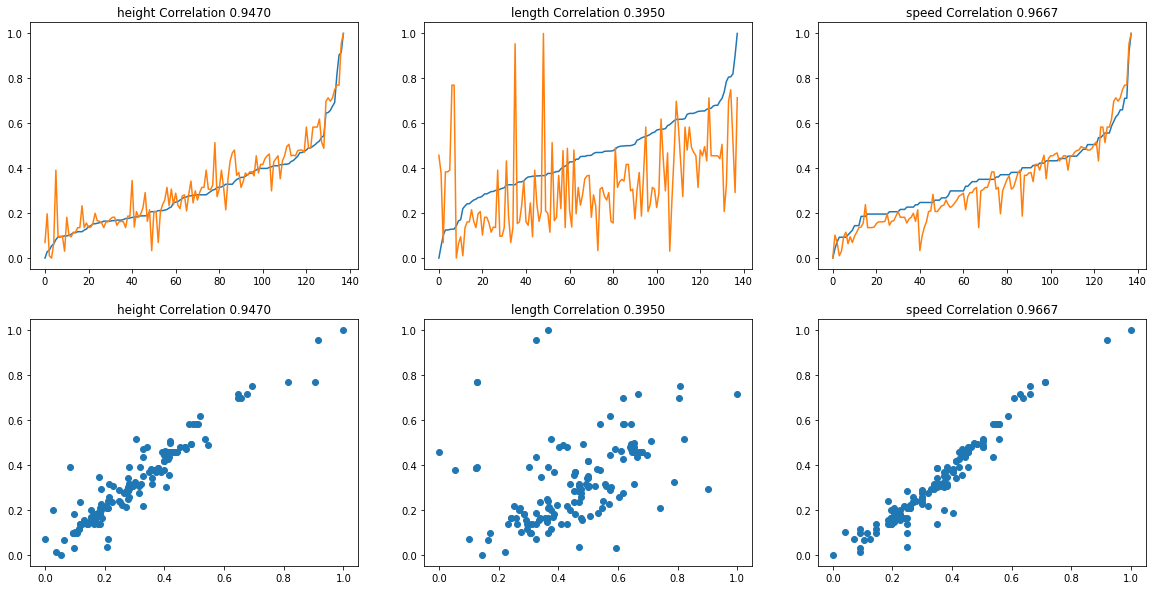

In [ ]:
from scipy.stats import pearsonr

names = ["height", "length", "speed"]
converted_list = [all_scaled_y_data[i][0] for i in range(len(all_scaled_y_data))]
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
for x in range(3):
  tmp_list = [all_scaled_data[i][x] for i in range(len(all_scaled_data))]
  linked_list = [[tmp_list[i], converted_list[i]] for i in range(len(tmp_list))]
  linked_list.sort()
  ax[0][x].plot(linked_list)

  ### Scatter
  feature1 = [linked_list[i][0] for i in range(len(linked_list))]
  feature2 = [linked_list[i][1] for i in range(len(linked_list))]
  ax[1][x].scatter(feature1, feature2)

  coeff = pearsonr(tmp_list, converted_list)[0]
  ax[0][x].set_title("%s Correlation %.4f" % (names[x], coeff))
  ax[1][x].set_title("%s Correlation %.4f" % (names[x], coeff))

plt.show()